**Society of Petrophysicists and Well Log Analysts (SPWLA) Machine Learning 2020 Submission**   
Team Name: *Trash Pandas*  
Members: Kaelin Ellis   
School: University of Alaska Fairbanks   
Program: Petroleum Engineering

In [222]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import os
import statsmodels.api as sm

from sklearn.feature_selection import f_classif, f_regression, SelectKBest
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

**Introduction**   
A multitude of well logs are taken over a wells life. These include caliper, cnc, gamma ray, deep resistivity, medium resistivity, photo electric factor, and density. Two logs, compressional travel time (DTC) and shear travel time (DTS) are not always taken. It is the goal of this notebook to understand how well DTC and DTS can be synthesized from regression machine learning methods.   
Ultimately a *KNN model* was selected for the following reasons:   
1. Relatively simple model
2. Computationally inexpensive, compared to Random Forest with 100+ trees
3. Still performs well   
Random Forest very marginally outperformed KNN. It was the authors view that two models competiting with R squared scores of 0.98ish are relatively the same. So the simpler model was selected.

In [221]:
# modified plotting function from Yanxiang Yu

def result_plot(y_predict, y_real=Y, mdl='None'):
    
    N = len(y_real)
    
    # check the accuracy of predicted data and plot the result
    rsqr = r2_score(y_real, y_predict)
    rmse = np.sqrt(mean_squared_error(y_real, y_predict))
    
    print('R Squared Value: {:.4f}'.format(rsqr))        
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Number of Samples: {}'.format(N))
    
    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    
    # plt.subplot(2, 2, 1)
    axs[0,0].plot(y_real[:, 0], ls='--')
    axs[0,0].plot(y_predict[:, 0], ls='--')
    axs[0,0].legend(['True', 'Predicted'])
    axs[0,0].set_xlabel('Sample')
    axs[0,0].set_ylabel('DTC')
    axs[0,0].set_title('DTC Prediction Comparison')

    # plt.subplot(2, 2, 2)
    axs[0,1].plot(y_real[:, 1], ls='--')
    axs[0,1].plot(y_predict[:, 1], ls='--')
    axs[0,1].legend(['True', 'Predicted'])
    axs[0,1].set_xlabel('Sample')
    axs[0,1].set_ylabel('DTS')
    axs[0,1].set_title('DTS Prediction Comparison')
    
    # plt.subplot(2, 2, 3)
    axs[1,0].scatter(y_real[:, 0], y_predict[:, 0], marker='.')
    axs[1,0].set_xlabel('Real Value')
    axs[1,0].set_ylabel('Predicted Value')
    axs[1,0].set_title('DTC Prediction Comparison')
    
    # plt.subplot(2, 2, 4)
    axs[1,1].scatter(y_real[:, 1], y_predict[:, 1], marker='.')
    axs[1,1].set_xlabel('Real Value')
    axs[1,1].set_ylabel('Predicted Value')
    axs[1,1].set_title('DTS Prediction Comparison')
    
    # if mdl=='None':
        # fig.suptitle('Evaluation of ML Algorithim')
    # else:
        # fig.suptitle('Evaluation of '+str(mdl))

    plt.show()

In [216]:
# modified plotting function from Yanxiang Yu

def prediction_plot(y_pred):
    
    N = len(y_pred)
    
    print('Number of Samples: {}'.format(N))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(y_pred[:, 0], ls='--', label='Predicted')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('DTC')
    ax1.legend()
    ax1.set_title('DTC Prediction Comparison')

    ax2.plot(y_pred[:, 1], ls='--', label='Predicted')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('DTS')
    ax2.legend()
    ax2.set_title('DTS Prediction Comparison')

    plt.show()

In [220]:
# os.getcwd()
# os.listdir()

In [3]:
df = pd.read_csv('train.csv')
df.columns = df.columns.str.lower()
df = df.replace(-999.0, np.nan)
df = df.dropna()

# drop the outliers, twice
df = df[(np.abs(stats.zscore(df))<3).all(axis=1)]
df = df[(np.abs(stats.zscore(df))<3).all(axis=1)]

# large amount of photoelectric data near 0
# should drop those...
# df = df[df['pe']>=0.75] # may need two datasets here, one for photo electric >0.75 and photo electric < 0.75

df = df.reset_index(drop=True)

In [4]:
# cal - caliper, inches
# cnc - neutron, dec
# gr - gamma ray, API
# hrd - deep resistivity, Ohm/meter
# hrm - medium resistivity, Ohm/meter
# pe - photoelectric factor, Barn
# zden - density, Gram/m^3
# dtc - compressional traveltime, nanosecond/foot
# dts - shear traveltime logs, nanosecond/foot

df.head()

,cal,cnc,gr,hrd,hrm,pe,zden,dtc,dts
0,13.4571,0.4821,61.1278,1.7827,1.3871,6.6690,2.1394,127.0895,309.3540
1,13.4091,0.4821,62.9978,1.7049,1.3211,6.5535,2.1370,127.4648,312.7448
2,13.2954,0.4689,64.6493,1.6703,1.3012,6.6136,2.1395,127.6743,315.0485
3,13.2840,0.4865,65.5135,1.6453,1.2897,6.6984,2.1377,127.7576,316.3320
4,13.2074,0.5046,64.0752,1.6141,1.2786,6.6727,2.1378,127.7952,316.8430


**Data Visualization**   
The feature values were graphed against DTC. It is recognized that DTC and DTS are closely correlated. A hypothesis that works well on DTC should also would well on DTS.

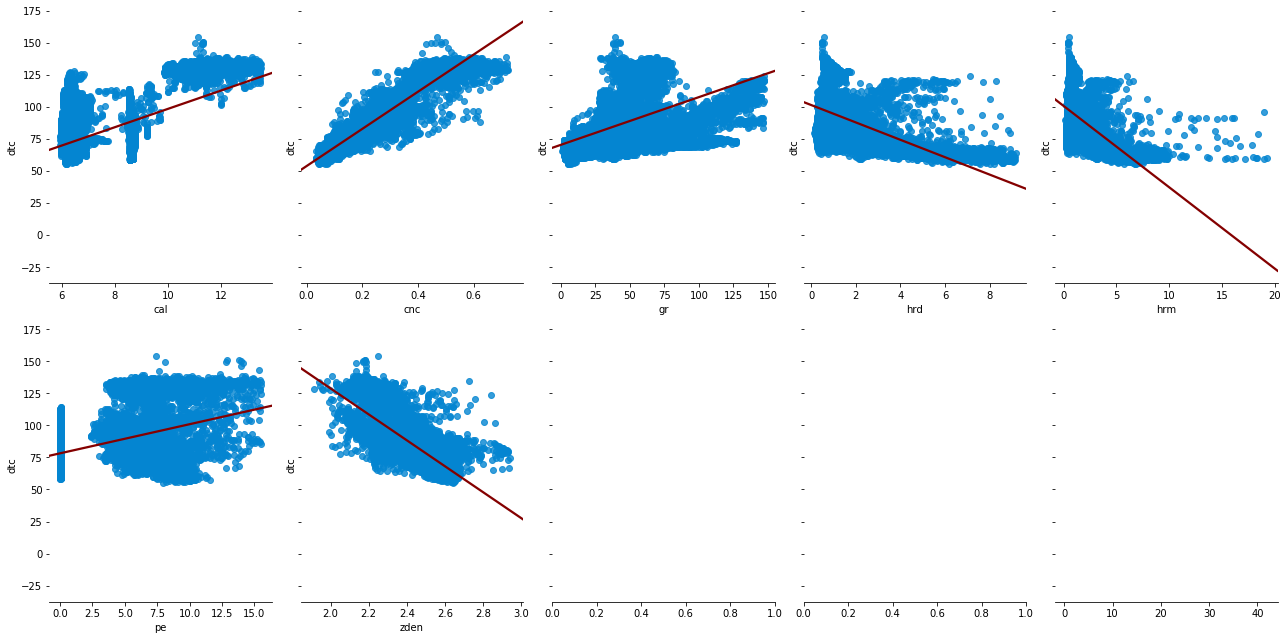

In [5]:
# make a list of only the numerical columns of input
# so don't care about the string and Y outputs

olist = list(df.columns) # original list
yvlist = list(['dtc']) # y variable list
stlist = list(['dts']) # string list

rmlist = yvlist+stlist # remove list

# make a new list of only the values I want to compare
xvlist = [x for x in olist if x not in rmlist]

fcol = 5 # limit five graphs per row for easy visualization
frow = int(np.ceil(len(xvlist)/fcol)) # number of rows in your subplot
fhgt = frow*4.5 # set how tall you want the subplot, 4.5 per row seems chill

# Set up the matplotlib figure
f, axes = plt.subplots(frow, fcol, figsize=(18, fhgt), sharey=True) #maybe mess around with auto generate figsize?
sns.despine(left=True)

# make a list of items to iterate over to produce graph
axes_list = [item for sublist in axes for item in sublist]

for k, xvar in enumerate(xvlist):
    
    sns.regplot(
        x=xvar, 
        y='dtc', 
        data=df, 
        ax=axes_list[k],
        ci = None, # set the confidence interval to none, so no resampling
        logx=False,
        scatter_kws={'color': 'xkcd:cerulean'}, # using xkcd color codes, https://xkcd.com/color/rgb/
        line_kws={'color': '#840000'} # using hex color codes
    )

plt.tight_layout()

**Evaluate Performance of Log Transforms**   
1. Deep resistivity
1. Medium resistivity   
   
   From the below graphs it can be seen that the two resistivity plots have a log distribution. Graphs were produced to understand how well log approximation could explain these two variables. Ultimately the normal features were selected instead of log. The two dominate regression models, KNN and Decision Trees, seemed to handle the log based data well. 

C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


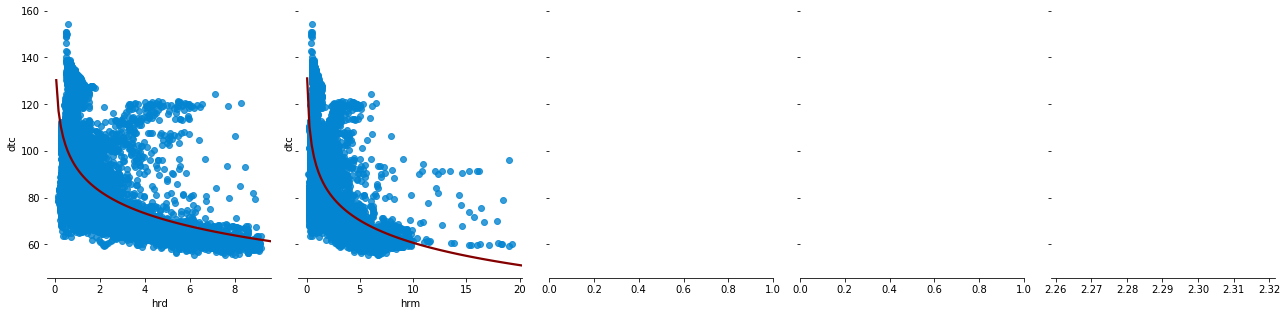

In [62]:
# make a list of only the numerical columns of input
# so don't care about the string and Y outputs

olist = list(('hrd', 'hrm')) # original list
yvlist = list(['dtc']) # y variable list
stlist = list(['dts']) # string list

rmlist = yvlist+stlist # remove list

# make a new list of only the values I want to compare
xvlist = [x for x in olist if x not in rmlist]

fcol = 5 # limit five graphs per row for easy visualization
frow = int(np.ceil(len(xvlist)/fcol)) # number of rows in your subplot
fhgt = frow*4.5 # set how tall you want the subplot, 4.5 per row seems chill

# Set up the matplotlib figure
f, axes = plt.subplots(frow, fcol, figsize=(18, fhgt), sharey=True) #maybe mess around with auto generate figsize?
sns.despine(left=True)

# make a list of items to iterate over to produce graph
axes_list = list(axes)

for k, xvar in enumerate(xvlist):
    
    sns.regplot(
        x=xvar, 
        y='dtc', 
        data=df, 
        ax=axes_list[k],
        ci = None, # set the confidence interval to none, so no resampling
        logx=True,
        scatter_kws={'color': 'xkcd:cerulean'}, # using xkcd color codes, https://xkcd.com/color/rgb/
        line_kws={'color': '#840000'} # using hex color codes
    )

plt.tight_layout()

**Data Distributions**   
Photoelectric Factor appears to have a large amount of data that is under 0.75 but seems to not fit the other existing data. This data was removed in other model notebooks but little benefit was seen in KNN and Decision Trees. As a result the data was left in place to maintain consistency. A geophysicist could explain whether this data should be removed or not with the appropriate domain knowledge.

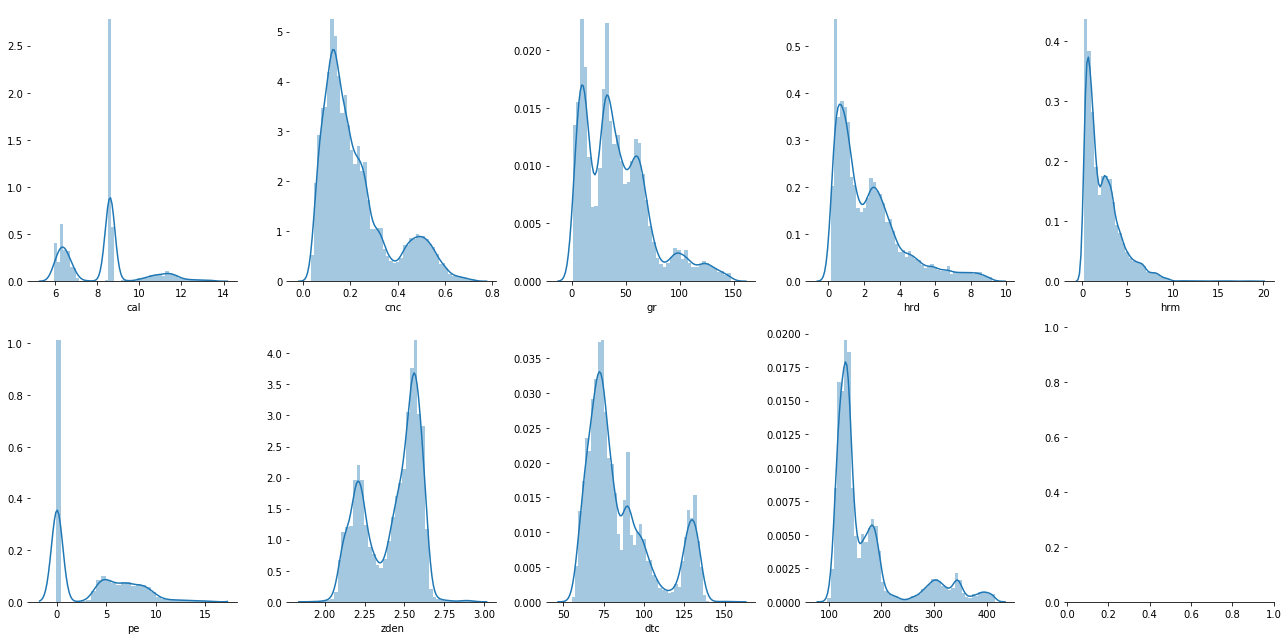

In [6]:
# make a list of only the numerical columns of input
# so don't care about the string and Y outputs

olist = list(df.columns) # original list

fcol = 5 # limit five graphs per row for easy visualization
frow = int(np.ceil(len(olist)/fcol)) # number of rows in your subplot
fhgt = frow*4.5 # set how tall you want the subplot, 4.5 per row seems chill

# Set up the matplotlib figure
f, axes = plt.subplots(frow, fcol, figsize=(18, fhgt), sharey=False) #maybe mess around with auto generate figsize?
sns.despine(left=True)

# make a list of items to iterate over to produce graph
axes_list = [item for sublist in axes for item in sublist]

for k, xvar in enumerate(olist):
    
    sns.distplot(
        df[xvar],
        ax=axes_list[k],
        norm_hist = True,
        #hist_kws={'color': 'xkcd:cerulean'}, # using xkcd color codes, https://xkcd.com/color/rgb/
        #rug_kws={'color': '#840000'} # using hex color codes
    )

plt.tight_layout()

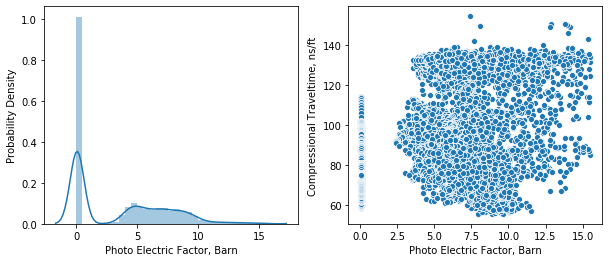

In [259]:
x_var = 'pe'
y_var = 'dtc'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(
    df[x_var],
    ax=ax1,
    norm_hist = True)

# ax1.hist(x_scat, density=1)
ax1.set_xlabel('Photo Electric Factor, Barn')
ax1.set_ylabel('Probability Density')
ax1.set_title('')

sns.scatterplot(
    x = x_var,
    y = y_var,
    data=df,
    ax=ax2)

# ax2.plot(x_scat, y_scat, ls='', marker='.')
ax2.set_xlabel('Photo Electric Factor, Barn')
ax2.set_ylabel('Compressional Traveltime, ns/ft')
ax2.set_title('')

# fig.suptitle('Random Forest Regression Tree Size Comparison', color='k')

plt.show()

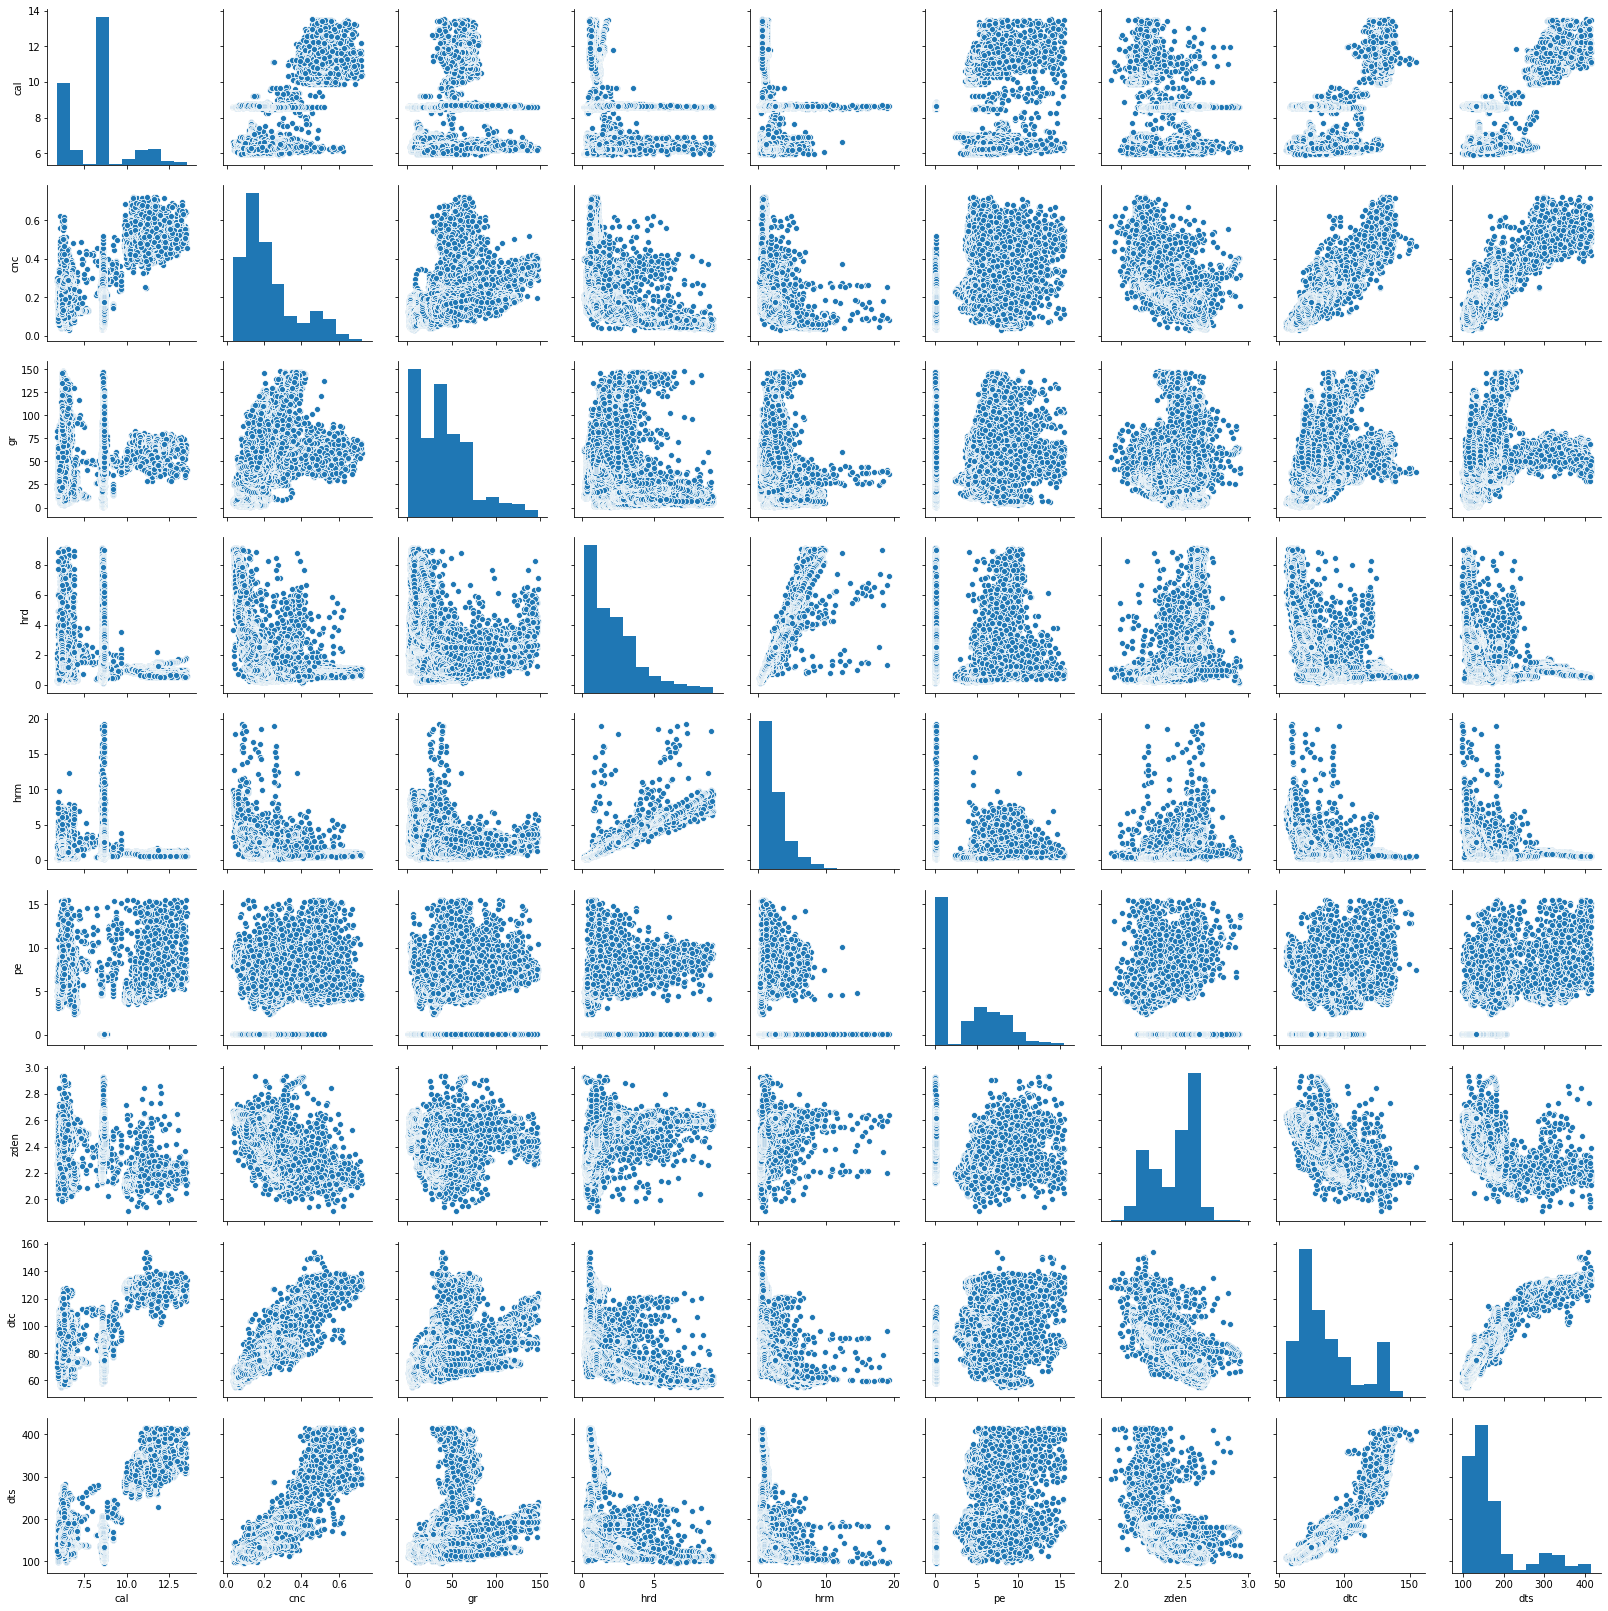

In [7]:
sns.pairplot(df)
plt.show()

In [8]:
df.describe()

,cal,cnc,gr,hrd,hrm,pe,zden,dtc,dts
count,18081.000000,18081.000000,18081.000000,18081.000000,18081.000000,18081.000000,18081.000000,18081.000000,18081.000000
mean,8.270928,0.222175,42.053336,2.261448,2.318825,3.443246,2.423023,86.021075,172.506024
std,1.650862,0.142888,30.717290,1.877405,1.980097,3.803466,0.171303,21.695428,72.446825
min,5.930400,0.032400,1.038900,0.129500,0.185300,-0.013100,1.914200,55.407600,96.900500
25%,6.603700,0.119900,15.615800,0.825700,0.808400,0.050200,2.246500,70.350600,127.019400
50%,8.578100,0.177400,36.121200,1.742300,1.752700,0.077000,2.482700,77.850700,139.877900
75%,8.625000,0.273100,59.456800,3.109700,3.255700,6.676600,2.564300,96.479000,183.921500
max,13.511500,0.724300,147.442300,9.165500,19.296900,15.526300,2.939000,154.456200,415.946700


In [67]:
# grab raw values to spot check
x_nms = ['cal', 'cnc', 'gr', 'hrd', 'hrm', 'pe', 'zden']
y_nms = ['dtc', 'dts']
y1_nms = ['dtc']
y2_nms = ['dts']

X = df[x_nms].values
Y = df[y_nms].values
Y1 = df[y1_nms].values
Y2 = df[y2_nms].values

**Attribute Performance**   
General analysis to rank feature importance. All the features were kept, as the model performed well with all of them and the competition stated to keep the features.

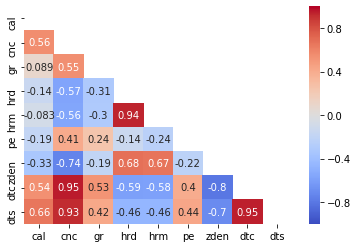

In [249]:
corl = df.corr()
# corl[np.abs(corl)<.2] = 0 # anything below a 0.3 correlation is set to zero in the results

masq = np.zeros_like(corl, dtype=np.bool)
masq[np.triu_indices_from(masq)] = True

sns.heatmap(corl, cmap = 'coolwarm', vmin=-1, vmax=1, annot=True, mask = masq)
plt.show()

In [11]:
X_sm = sm.add_constant(X)
results=sm.OLS(Y1, X_sm).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 4.589e+04
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:51:16   Log-Likelihood:                -54782.
No. Observations:               18081   AIC:                         1.096e+05
Df Residuals:                   18073   BIC:                         1.096e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.6387      1.007    147.553      0.0

In [12]:
# feature selection for classif
fvalues, pvalues = f_regression(X, Y1.ravel())
print('F Values')
print(fvalues)
print('P Values')
print(pvalues)

F Values
[  7606.12143    183304.83881154   6950.02243718   9476.89963404
   9126.61954825   3424.14166472  32023.73381194]
P Values
[0. 0. 0. 0. 0. 0. 0.]


**Spot Check Regression Algorithms**

In [13]:
kfold = KFold(n_splits=5, random_state=7, shuffle=True)

reg = LinearRegression(normalize=False)
cv_results = cross_val_score(reg, X, Y1, cv=kfold)
print('Regression with DTC')
print(cv_results)

Regression with DTC
[0.94176866 0.94820645 0.94459127 0.94662461 0.95192182]


In [14]:
ridge = Ridge(alpha=0.002, normalize=True)
cv_results = cross_val_score(ridge, X, Y1, cv=kfold)
print('Ridge with DTC')
print(cv_results)

Ridge with DTC
[0.94173436 0.94823473 0.94458894 0.94663464 0.95191669]


In [15]:
lasso = Lasso(alpha=0.002, normalize=True)
cv_results = cross_val_score(lasso, X, Y1, cv=kfold)
print('Lasso with DTC')
print(cv_results)

Lasso with DTC
[0.94134227 0.94765337 0.94391371 0.94585023 0.9506289 ]


**Spot Check Nonlinear Algorithms**

In [16]:
knn = KNeighborsRegressor()
cv_results = cross_val_score(knn, X, Y1, cv=kfold)
print('KNN with DTC')
print(cv_results)

KNN with DTC
[0.9442697  0.95145347 0.94824189 0.94378754 0.95560981]


In [17]:
dtree = DecisionTreeRegressor()
cv_results = cross_val_score(dtree, X, Y1, cv=kfold)
print('Decision Tree with DTC')
print(cv_results)

Decision Tree with DTC
[0.96830475 0.96938808 0.96959894 0.97041425 0.97351277]


In [18]:
svr = SVR(gamma='auto')
cv_results = cross_val_score(svr, X, Y1.ravel(), cv=kfold)
print('SVR with DTC')
print(cv_results)

SVR with DTC
[0.90673616 0.90446565 0.9096823  0.90585856 0.91160959]


**Compare Machine Learning Algorithms**

In [223]:
models = [
    ('LinReg', LinearRegression(normalize=False)),
    ('Ridge', Ridge(alpha=0.002, normalize=False)),
    ('Lasso', Lasso(alpha=0.002, normalize=False)),
    ('KNN', KNeighborsRegressor()),
    ('DecTree', DecisionTreeRegressor()),
    ('SVR', SVR(gamma='auto')),
    # ('MLP', MLPRegressor())
]

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    if name in ('SVR', 'MLP')::
        cv_results = cross_val_score(model, X, Y1.ravel(), cv=kfold)
    else:
        cv_results = cross_val_score(model, X, Y1, cv=kfold)
    results.append(cv_results)
    names.append(name)

C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilaye

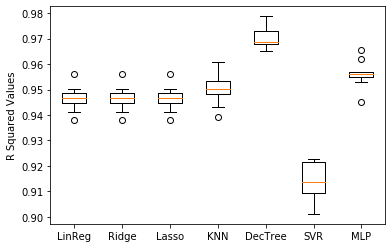

In [260]:
fig = plt.figure()    
# fig.suptitle('Rough Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('R Squared Values')
plt.show()

In [263]:
for key, val in dict(zip(names, results)).items():
    print(key, round(np.mean(val), 3))

LinReg 0.947
Ridge 0.947
Lasso 0.947
KNN 0.95
DecTree 0.97
SVR 0.914
MLP 0.956


**Evaluate Algorithms: Standardization**   
Transform the data so each feature has a mean value of zero and a standard deviation of 1.   

In [225]:
# make a series of pipelines to standardize the data
st_pre = 'St_' # attach following prefix to denote a standardized dataset

pipelines = []
for name, model in models:
    pipelines.append((st_pre+name, Pipeline([('Scaler', StandardScaler()), (name, model)])))

In [226]:
st_results = []
st_names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    if name in (st_pre+'SVR', st_pre+'MLP'):
        cv_results = cross_val_score(model, X, Y1.ravel(), cv=kfold)
    else:
        cv_results = cross_val_score(model, X, Y1, cv=kfold)
    st_results.append(cv_results)
    st_names.append(name)

C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\kaelie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Max

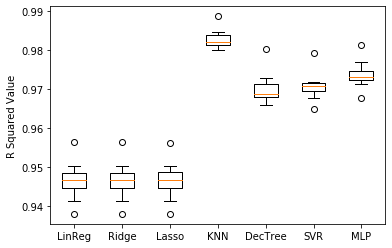

In [262]:
fig = plt.figure()    
# fig.suptitle('Algorithm Comparison with Standardized Datasets')
ax = fig.add_subplot(111)
plt.boxplot(st_results)
ax.set_xticklabels(names)
ax.set_ylabel('R Squared Value')
plt.show()

In [32]:
for key, val in dict(zip(st_names, st_results)).items():
    print(key, round(np.mean(val), 3))

St_LinReg 0.947
St_Ridge 0.947
St_Lasso 0.947
St_KNN 0.983
St_DecTree 0.97
St_SVR 0.971


**Tuning Hyperparameters for Lasso Regression**   
Desired to see if tuning the lambda/alpha hyperparameter on lasso regression would have an impact in performance of the machine learning model. In the graph below it can be seen that they do not.

In [157]:
alpha_vals = np.logspace(-4, -1, 30)

scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

split_num = 10
kfold = KFold(n_splits=split_num, random_state=7, shuffle=True)

param_grid = dict(alpha=alpha_vals)

lasso = Lasso()
lasso_grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=kfold)
lg_rslt = lasso_grid.fit(rescaledX, Y1)

# ridge results don't do too much...
ridge = Ridge()
ridge_grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=kfold)
rg_rslt = ridge_grid.fit(rescaledX, Y1)

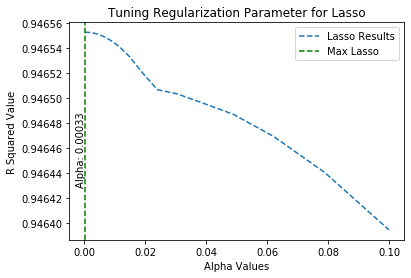

In [158]:
plt.plot(alpha_vals, lg_rslt.cv_results_['mean_test_score'], label='Lasso Results', ls='--', marker='')
# plt.plot(alpha_vals, rg_rslt.cv_results_['mean_test_score'], label='Ridge Results', ls='--', marker='')

las_maxA = alpha_vals[np.argmax(lg_rslt.cv_results_['mean_test_score'])]
las_maxR = max(lg_rslt.cv_results_['mean_test_score'])

plt.axvline(las_maxA, label='Max Lasso', color='g', ls='--')

ymin, ymax = plt.ylim()
ypos = ymin+(ymax-ymin)/4

plt.text(x = las_maxA-0.0032, y = ypos, s = 'Alpha: {:.5f}'.format(las_maxA), rotation=90)

plt.xlabel('Alpha Values')
plt.ylabel('R Squared Value')
plt.title('Tuning Regularization Parameter for Lasso')
plt.legend()
plt.show()

**Tuning Hyperparameters for KNN**   
Default value of KNN is 5, will loop through to see how it reacts with values from 1 to 21. Since KNN had a strong base performance by using a standardized dataset it was selected for more hyperparameter tuning. The neighbors had the strongest performance influence. Using voting logic with distance had a positive influence. The leaf size didn't have much affect on model score, but did control how long the model ran.

In [24]:
k_values = np.arange(1,23,2)

scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

split_num = 10

param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=split_num, random_state=7, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(rescaledX, Y1)

split_rslt = []
for i in range(split_num):
    split_rslt.append(grid_result.cv_results_['split'+str(i)+'_test_score'])   
split_rslt = np.asarray(split_rslt)

knn_rslt = {}
for i, k_val in enumerate(k_values):
    knn_rslt.update({k_val:split_rslt[:,i]})

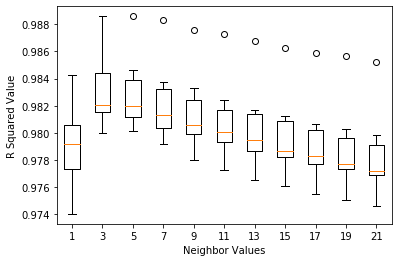

In [264]:
fig = plt.figure()    
# fig.suptitle('Comparing Size of Neighbors for KNN')
ax = fig.add_subplot(111)
plt.boxplot(knn_rslt.values())
ax.set_xticklabels(knn_rslt.keys())
ax.set_xlabel('Neighbor Values')
ax.set_ylabel('R Squared Value')
plt.show()

In [36]:
for key, val in knn_rslt.items():
    print(key, round(np.mean(val), 4))

1 0.979
3 0.983
5 0.9828
7 0.982
9 0.9814
11 0.9807
13 0.9802
15 0.9796
17 0.9791
19 0.9786
21 0.9782


**Evaluate KNN hyperparameters, Weights and Algorithm**

In [160]:
knn_params = {
    'n_neighbors':[3, 5, 7],
    'weights':['uniform', 'distance'],
    'algorithm':['ball_tree', 'kd_tree', 'brute']
}

it_knn = KNeighborsRegressor()

scaler = StandardScaler().fit(X)
X_scale = scaler.transform(X)

kfold = KFold(n_splits=num_folds, random_state=rdm_ste, shuffle=True)

grid_knn = GridSearchCV(estimator=it_knn, param_grid=knn_params, cv=kfold, scoring='r2')
grid_knn_result = grid_knn.fit(X_scale, Y)

In [161]:
grid_knn_result.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}

**Evaluate KNN Hyperparameters, Leafs**

In [162]:
leaf_params = {
    'leaf_size':np.arange(1, 40, 1)
}

leaf_knn = KNeighborsRegressor(
    algorithm='ball_tree', 
    n_neighbors=3,
    weights='distance')

scaler = StandardScaler().fit(X)
X_scale = scaler.transform(X)

kfold = KFold(n_splits=num_folds, random_state=rdm_ste, shuffle=True)

grid_leaf = GridSearchCV(estimator=leaf_knn, param_grid=leaf_params, cv=kfold, scoring='r2')
grid_leaf_result = grid_leaf.fit(X_scale, Y)

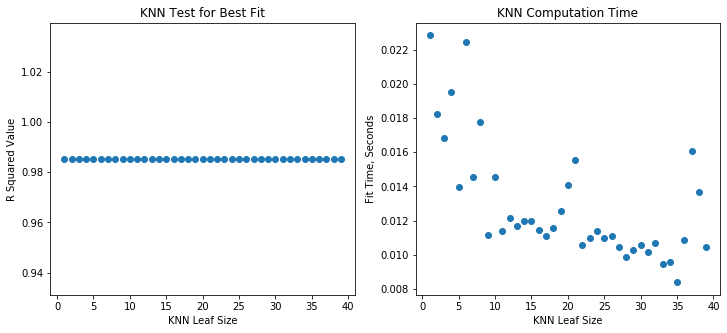

In [163]:
leaf_time = grid_leaf_result.cv_results_['mean_fit_time']
leaf_score = grid_leaf_result.cv_results_['mean_test_score']
leafs = leaf_params['leaf_size']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(leafs, leaf_score, ls='', marker='o')
ax1.set_xlabel('KNN Leaf Size')
ax1.set_ylabel('R Squared Value')
ax1.set_title('KNN Test for Best Fit')

ax2.plot(leafs, leaf_time, ls='', marker='o')
ax2.set_ylabel('Fit Time, Seconds')
ax2.set_xlabel('KNN Leaf Size')
ax2.set_title('KNN Computation Time')

# fig.suptitle('Random Forest Regression Tree Size Comparison', color='k')

plt.show()

**Evaluate Enssemble Methods**   
Boosting Methods: AdaBoost(AB) and Gradient Boosting (GBM)   
Bagging Methods: Random Forests (RF) and Extra Trees (ET)

In [228]:
ensembles = [
    ('ScaledAB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])),
    ('ScaledGBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])),
    ('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor(n_estimators=10))])),
    ('ScaledET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor(n_estimators=10))]))
]

split_num = 10
kfold = KFold(n_splits=split_num, random_state=7, shuffle=True)

en_results = []
en_names = []

for name, model in ensembles:
    cv_results = cross_val_score(model, X, Y1.ravel(), cv=kfold)
    en_results.append(cv_results)
    en_names.append(name)

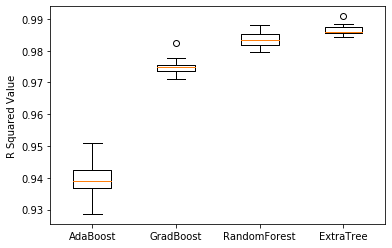

In [268]:
ep_names = [
    'AdaBoost',
    'GradBoost',
    'RandomForest',
    'ExtraTree'
]

fig = plt.figure()    
# fig.suptitle('Ensemble Comparison with Standardized Datasets')
ax = fig.add_subplot(111)
plt.boxplot(en_results)
ax.set_xticklabels(ep_names)
ax.set_ylabel('R Squared Value')
plt.show()

In [230]:
for key, val in dict(zip(en_names, en_results)).items():
    print(key, round(np.mean(val), 4))

ScaledAB 0.9395
ScaledGBM 0.9752
ScaledRF 0.9836
ScaledET 0.9864


**Tune Random Forrest Model**   
Plot was generated to evaluate model performance and computation time as the number of trees were increased. As theorized the model peaked at around 100 trees with performance. After the increase in trees just lead to more computational resource required.

In [241]:
n_est = [5, 10, 25, 50, 100, 200, 300]

params_rfr = {
    #'max_depth':np.arange(3, 8, 1),
    #'max_features':[0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators':n_est,
}

scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

RanForReg = RandomForestRegressor()
# RanForReg.fit(rescaledX, Y1.ravel())

split_num = 10
kfold = KFold(n_splits=split_num, random_state=7, shuffle=True)

grid_rfr = GridSearchCV(estimator=RanForReg, param_grid=params_rfr, cv=kfold, scoring='r2')
grid_rfr_result = grid_rfr.fit(rescaledX, Y1.ravel())

split_rslt = []
for i in range(split_num):
    split_rslt.append(grid_rfr_result.cv_results_['split'+str(i)+'_test_score'])   
split_rslt = np.asarray(split_rslt)

rfr_rslt = {}
for i, n_val in enumerate(n_est):
    rfr_rslt.update({n_val:split_rslt[:,i]})

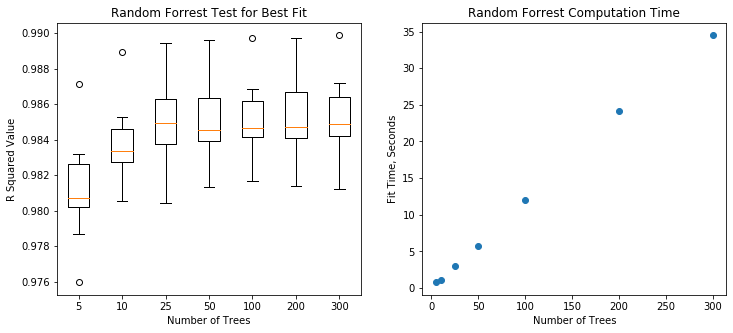

In [242]:
fit_time = grid_rfr_result.cv_results_['mean_fit_time']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot(rfr_rslt.values())
ax1.set_xticklabels(rfr_rslt.keys())
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('R Squared Value')
ax1.set_title('Random Forrest Test for Best Fit')

ax2.plot(n_est, fit_time, ls='', marker='o')
ax2.set_ylabel('Fit Time, Seconds')
ax2.set_xlabel('Number of Trees')
ax2.set_title('Random Forrest Computation Time')

# fig.suptitle('Random Forest Regression Tree Size Comparison', color='k')

plt.show()

In [243]:
for key, val in rfr_rslt.items():
    print(key, round(np.mean(val), 4))

5 0.9812
10 0.9838
25 0.9849
50 0.985
100 0.9852
200 0.9852
300 0.9853


**Tune Extra Trees Model** 

In [246]:
n_est = [5, 10, 25, 50, 100, 200, 300]

params_etr = {
    #'max_depth':np.arange(3, 8, 1),
    #'max_features':[0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators':n_est,
}

ExTreReg = ExtraTreesRegressor()
# RanForReg.fit(rescaledX, Y1.ravel())

scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

split_num = 10
kfold = KFold(n_splits=split_num, random_state=7, shuffle=True)

grid_xtr = GridSearchCV(estimator=ExTreReg, param_grid=params_etr, cv=kfold, scoring='r2')
grid_xtr_result = grid_xtr.fit(rescaledX, Y1.ravel())

split_rslt = []
for i in range(split_num):
    split_rslt.append(grid_xtr_result.cv_results_['split'+str(i)+'_test_score'])   
split_rslt = np.asarray(split_rslt)

xtr_rslt = {}
for i, n_val in enumerate(n_est):
    xtr_rslt.update({n_val:split_rslt[:,i]})

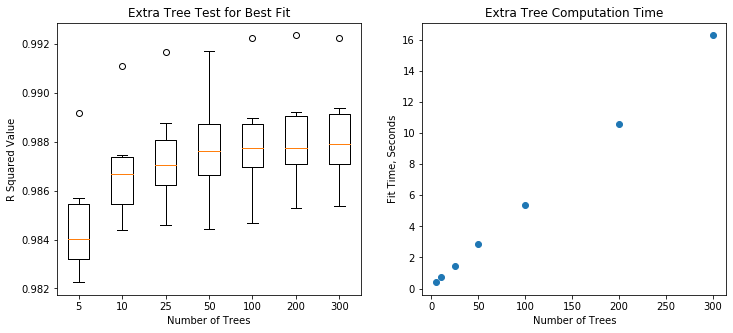

In [247]:
xtr_time = grid_xtr_result.cv_results_['mean_fit_time']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot(xtr_rslt.values())
ax1.set_xticklabels(xtr_rslt.keys())
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('R Squared Value')
ax1.set_title('Extra Tree Test for Best Fit')

ax2.plot(n_est, xtr_time, ls='', marker='o')
ax2.set_ylabel('Fit Time, Seconds')
ax2.set_xlabel('Number of Trees')
ax2.set_title('Extra Tree Computation Time')

# fig.suptitle('Random Forest Regression Tree Size Comparison', color='k')

plt.show()

In [248]:
for key, val in xtr_rslt.items():
    print(key, round(np.mean(val), 4))

5 0.9845
10 0.9866
25 0.9874
50 0.9878
100 0.9879
200 0.9881
300 0.9882


**Select appropriate Machine Learning Model and Deploy**   
As stated in the introduction. A KNN model was selected for ultimate deployment. Using a standardized dataset provided comparable results to the random forrest model. KNN regression is computationally less expensive than random forrest. The author also wanted to deploy a model that was different than the example sheet.

In [194]:
num_folds=5
rdm_ste=100

st_knn = Pipeline([
    ('Scaler', StandardScaler()), 
    ('KNN', KNeighborsRegressor(
        algorithm='ball_tree', 
        n_neighbors=3,
        weights='distance'))
])

kfold = KFold(n_splits=num_folds, random_state=rdm_ste, shuffle=True)
st_knn_r2 = cross_val_score(st_knn, X, Y, cv=kfold, scoring='r2')
st_knn_mse = cross_val_score(st_knn, X, Y, cv=kfold, scoring='neg_mean_squared_error')
st_knn_rmse = np.sqrt(np.abs(st_knn_mse))

print('Avg. R Sqr: {:.3f}\nAvg. MSE: {:.3f}\nAvg. RMSE: {:.3f}'.format(
    np.mean(st_knn_r2),
    np.mean(st_knn_mse),
    np.mean(st_knn_rmse)))

Avg. R Sqr: 0.984
Avg. MSE: -41.864
Avg. RMSE: 6.467


**Visualize model performance on test set**

R Squared Value: 0.9846
Root Mean Square Error: 6.7056
Number of Samples: 3617


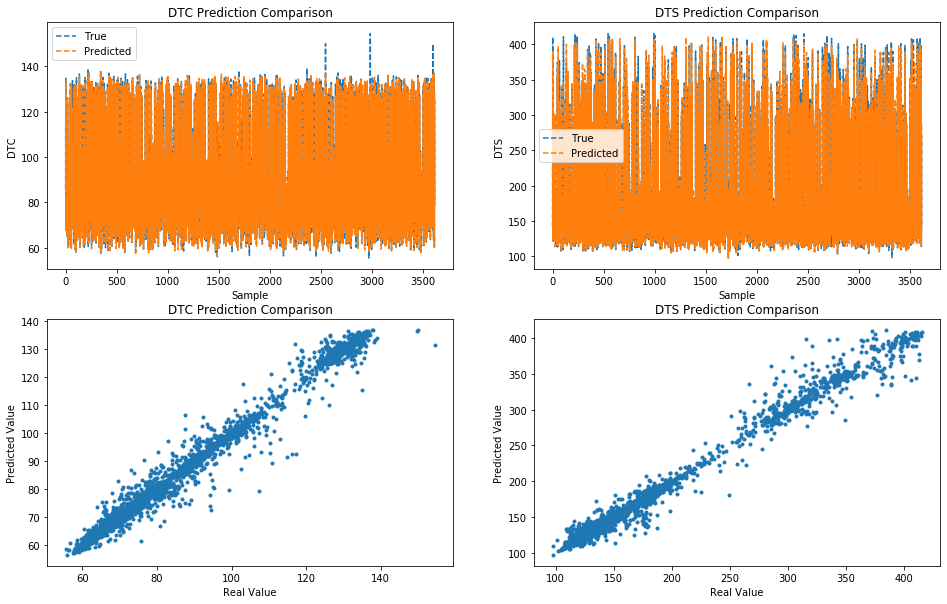

In [195]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=100)

st_knn.fit(X_train, Y_train)
result_plot(st_knn.predict(X_test), Y_test)

One issues I've learned about KNN, it is dependant on train size vs. test size. Meaning that if you have a very small train set compared to test that your results will potentially be worse than having a large test vs train. Not sure if Random Forrest has this issue as well or not. Not significant, but it is there.

**Deploy model on validation set of second well**

In [198]:
dfw2 = pd.read_csv('test.csv')
dfw2.columns = dfw2.columns.str.lower()
dfw2 = dfw2.replace(-999.0, np.nan)
dfw2 = dfw2.dropna()
dfw2.head()

,cal,cnc,gr,hrd,hrm,pe,zden
0,8.5781,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256
1,8.5781,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255
2,8.5781,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212
3,8.5625,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119
4,8.5781,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982


In [202]:
Xw2 = np.asarray(dfw2)
w2_pred = st_knn.predict(Xw2)

Number of Samples: 11088


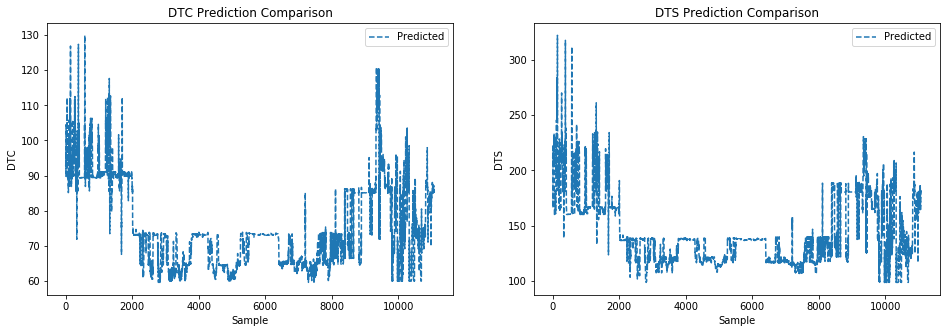

In [212]:
prediction_plot(w2_pred)

In [217]:
w2_out = pd.DataFrame({
    'DTC':w2_pred[:,0],
    'DTS':w2_pred[:,1],
})

w2_out.head()

,DTC,DTS
0,92.985576,211.653177
1,92.876972,211.362231
2,92.932613,211.339670
3,93.120551,211.585600
4,96.395631,215.365733


In [218]:
# w2_out.to_csv('ellis_submission1.csv', index=False)